---
# 0. 라이브러리
----

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
from collections import Counter

In [2]:
cd /content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/

/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data


---
# 1. Data
----

In [3]:
class Config():
  train = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/train.csv'
  test = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/test.csv'
  sub = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sample_submission.csv'
  epoch = 100
  num_worker = 5
  lr = 1e-4
  sr = 16000
  batch_size = 64


config = Config()

In [4]:
train = pd.read_csv(config.train)
test = pd.read_csv(config.test)
train

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


---
# 2. Preprocessing
---

- Positive FFT
  - 신호의 양의 주파수 성분만 반환하는 FFT 알고리즘의 변형

  - 0Hz 보다 큰 주파수이며 신호 주파수 스팩트럼의 오른쪽 절반에 해당함

  - 양의 주파수 성분만 관심있는 오디오 신호 처리에 유용

- np.linespace 

  - 지정된 간격에 걸쳐 균등하게 간격을 둔 샘플의 1D 배열을 생성
  - Start : 시퀀스의 시작 값
  - Stop : 시퀀스의 끝 값
  - Num : 생성할 샘플 수 
  - endpoint 빈도 값 범위에 대한 앤드포인트 포함 여부

- Y =2*np.abs(Y[0:N])/(L/2)

  - 먼저 Y[0:N]는 양의 주파수 성분에 해당하는 FFT의 첫 번째 N개 값만 선택하는 데 사용

  - np.abs(Y[0:N])를 사용하여 양의 주파수 성분의 크기를 반환하는 복소수의 절대값 계산

  - 2*np.abs(Y[0:N])를 사용하여 양의 주파수 성분의 크기를 2배로 조정

  - FFT가 양변 스펙트럼을 반환하기 때문에 즉, 음의 주파수가 원점 주위에 반사되기 때문  
    따라서 양 및 음의 주파수 성분은 중복되며 원래 신호의 최대 두 배의 에너지를 합하게 됨

  - 마지막으로 /(L/2)는 신호의 길이만큼 양의 주파수 성분을 정규화하는 데 사용   
    이는 양의 주파수 성분의 진폭이 원래 신호의 에너지를 반영하도록 하기 위해 수행

최종 결과물은 정확한 진폭과 에너지 표현으로 양의 주파수 성분을 반환하는 것     

In [5]:
# FFT Code
def PositiveFFT(Input_rawdata,Sampling_frequency=16000, Length=16000):

    
    Fs = Sampling_frequency  # 시간 단위로 수집되는 신호의 샘플 수 / 높을수록 더 많은 샘플을 추출해 고해상도 디지털 신호가 생성되나 계산비용의 증가됨
    
    Input_rawdata = np.hanning(Length)*Input_rawdata # hanning window 적용 
                                                     # 스펙트럼의 누출을 줄이고 신호의 주파수 영역표현을 정확하게 하기 위해 사용
    L = len(Input_rawdata)  # 신호의 전체 길이
    
    X = Input_rawdata
    Y = np.fft.fft(X)  # 신호의 전체 FFT 반환
    
    N = int(len(Y)/2)
    Y =2*np.abs(Y[0:N])/(L/2) # FFT의 양의 주파수 성분만 선택 

    freq = np.linspace(0, Fs/2, N, endpoint=True) # FFT의 주파수의 배열인 freq를 생성하고 FFT와 주파수를 튜플로 반환
                                                  # 양의 주파수 성분에 해당하는 주파수 값 배열을 생성
    return (Y,freq)

In [6]:
def FFT_Result(Data):
    
    STRIDE=16000 # 한 번에 입력 신호에서 추출할 샘플 수를 정의
    Fs=16000 # 샘플링 주파수 
    
    sample = [Data[i:i+Fs] for i in range(0, len(Data), STRIDE)] 

    # 주파수 및 진폭의 값을 저장하는 리스트 생성
    F=[]
    A=[]
    for samp in sample:
        y, freq = PositiveFFT(samp) # 진폭 값, 주파수 값 반환
        A.append(y)
    
    F=freq
    A=np.array(A).mean(axis=0) # 모든 진폭값의 평균 계산 
    
    return F, A # 지정된 입력 신호에 대한 FFT의 주파수 및 진폭 값 반환

In [7]:
def get_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        wav, sr = librosa.load(path, sr=config.sr)
        f, y = FFT_Result(wav)
        features.append(y)
    return np.array(features)

In [8]:
X_train=get_feature(train)
X_test=get_feature(test)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

---
# 3. Dataset & DataLoader
---

In [9]:
class custom_dataset(Dataset):
  
  def __init__(self, data):

    self.data = data

  def __len__(self):
    return len(self.data)
    

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.data[idx])
    return x


In [10]:
train_dataset = custom_dataset(X_train)
train_loader = DataLoader(dataset = train_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

test_dataset = custom_dataset(X_test)
test_loader = DataLoader(dataset = test_dataset, batch_size = config.batch_size, shuffle = False, drop_last = False)

---
# 4. Model
----

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim = 250):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(8000, 4000),
            nn.Linear(4000, 2000),
            nn.Linear(2000, 1000),
            nn.Linear(1000, 2 * latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.Linear(1000, 2000),
            nn.Linear(2000, 4000),
            nn.Linear(4000, 8000),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = x[:, : self.latent_dim  ], x[:, self.latent_dim  : ]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [12]:
model = VAE().to(device)
loss_fn = nn.BCELoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr = config.lr)

In [13]:
for i in train_loader:
  print(i.shape)
  break

torch.Size([64, 8000])


---
# 5. Train
---

In [14]:
def train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    for x in tqdm(data_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, log_var = model(x)
        recon_loss = loss_fn(x_recon, x)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(data_loader)

In [15]:
graph_loss = []

for epoch in range(config.epoch):
  
  loss = train(model,train_loader, loss_fn, optimizer, device)
  graph_loss.append(loss)
  print(f'Epoch : {epoch +1} Loss : {loss}')
  

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 1 Loss : 250284.79025878906


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 2 Loss : 5413.599395751953


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 3 Loss : 5105.169604492187


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 4 Loss : 2123.5912475585938


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 5 Loss : 1084.5421325683594


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 6 Loss : 814.0144958496094


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 7 Loss : 777.8805511474609


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 8 Loss : 696.5455963134766


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 9 Loss : 1796.1180297851563


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 10 Loss : 1361.4933959960938


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 11 Loss : 1021.565072631836


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 12 Loss : 795.2922637939453


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 13 Loss : 854.2150756835938


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 14 Loss : 1134.1487518310546


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 15 Loss : 1332.138461303711


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 16 Loss : 1361.8743865966796


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 17 Loss : 1367.808544921875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 18 Loss : 888.809848022461


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 19 Loss : 798.0894775390625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 20 Loss : 719.5223663330078


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 21 Loss : 733.0046081542969


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 22 Loss : 824.5709259033204


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 23 Loss : 720.7685028076172


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 24 Loss : 956.231478881836


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 25 Loss : 1049.376513671875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 26 Loss : 771.146762084961


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 27 Loss : 681.0743347167969


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 28 Loss : 662.4031921386719


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 29 Loss : 801.9373138427734


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 30 Loss : 2458.9201751708983


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 31 Loss : 3175.077880859375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 32 Loss : 1127.183755493164


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 33 Loss : 811.7857666015625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 34 Loss : 746.9331878662109


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 35 Loss : 852.1672943115234


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 36 Loss : 731.6088500976563


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 37 Loss : 767.6749206542969


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 38 Loss : 833.5395721435547


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 39 Loss : 816.1574096679688


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 40 Loss : 852.3659881591797


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 41 Loss : 913.8657104492188


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 42 Loss : 792.7562072753906


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 43 Loss : 644.1427612304688


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 44 Loss : 1276.4659545898437


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 45 Loss : 1180.9112884521485


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 46 Loss : 751.0830078125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 47 Loss : 774.8782989501954


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 48 Loss : 675.0033355712891


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 49 Loss : 766.1240264892579


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 50 Loss : 776.6603485107422


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 51 Loss : 693.2488555908203


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 52 Loss : 3212.782553100586


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 53 Loss : 1605.065267944336


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 54 Loss : 986.0990295410156


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 55 Loss : 1036.1490936279297


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 56 Loss : 777.2417785644532


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 57 Loss : 784.8046051025391


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 58 Loss : 711.5930389404297


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 59 Loss : 774.7994140625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 60 Loss : 1002.6367248535156


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 61 Loss : 790.7543701171875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 62 Loss : 720.5266326904297


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 63 Loss : 804.9921020507812


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 64 Loss : 863.7747619628906


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 65 Loss : 697.5036193847657


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 66 Loss : 732.9090850830078


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 67 Loss : 720.8955688476562


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 68 Loss : 778.8653869628906


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 69 Loss : 850.44091796875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 70 Loss : 736.7546234130859


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 71 Loss : 646.8673828125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 72 Loss : 617.2421630859375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 73 Loss : 1259.1507049560546


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 74 Loss : 1216.7726135253906


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 75 Loss : 856.17197265625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 76 Loss : 786.1127258300781


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 77 Loss : 946.0140960693359


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 78 Loss : 1091.9769439697266


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 79 Loss : 1111.528042602539


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 80 Loss : 1128.292807006836


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 81 Loss : 762.0605255126953


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 82 Loss : 729.63798828125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 83 Loss : 800.7983642578125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 84 Loss : 703.9028106689453


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 85 Loss : 941.3837799072265


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 86 Loss : 822.37646484375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 87 Loss : 685.7656494140625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 88 Loss : 674.1507965087891


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 89 Loss : 4199.168444824219


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 90 Loss : 1678.9316467285157


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 91 Loss : 862.8029632568359


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 92 Loss : 830.78828125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 93 Loss : 993.245654296875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 94 Loss : 1363.222430419922


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 95 Loss : 922.595980834961


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 96 Loss : 709.8838531494141


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 97 Loss : 727.6226226806641


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 98 Loss : 820.12841796875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 99 Loss : 672.5555938720703


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 100 Loss : 700.23388671875


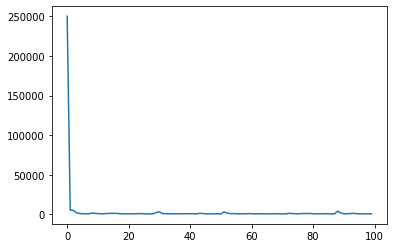

In [16]:
plt.plot(graph_loss)

---
# 6. Prediction
----

In [17]:
def test(model, data_loader, loss_fn, device):

  scores = []
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for x in tqdm(data_loader):
      x = x.to(device)
      x_recon, mu, log_var = model(x)
      recon_loss = loss_fn(x_recon, x)
      kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
      loss = recon_loss + kl_loss
      test_loss += loss.item()

      score = torch.mean(torch.abs(x - x_recon), axis = 1)
      scores.extend(score.cpu().numpy())

  return np.array(scores)


In [18]:
train_scores = test(model, train_loader, loss_fn, device)
test_scores = test(model, test_loader, loss_fn, device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [19]:
threshold = train_scores.max()
threshold

0.7571094

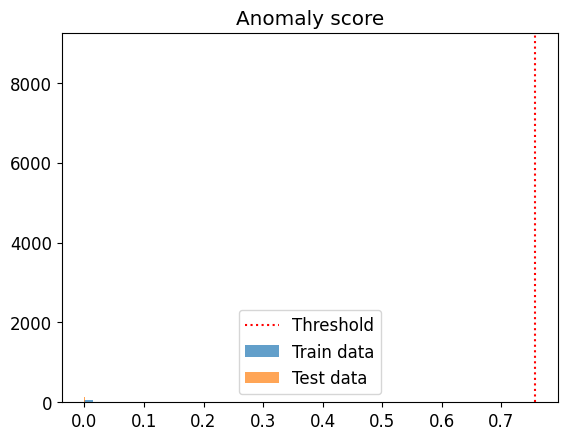

In [20]:
# 히스토그램
plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_scores, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_scores, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=threshold, c='red', linestyle=':', label='Threshold')
plt.title("Anomaly score")
plt.legend()

In [21]:
def get_pred_label(model_pred, t):
    # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred <= t, 0, model_pred)
    model_pred = np.where(model_pred > t, 1, model_pred)
    return model_pred

In [22]:
train_pred = get_pred_label(train_scores, threshold)
Counter(train_pred)

Counter({0.0: 1279})

In [23]:
test_pred = get_pred_label(test_scores, threshold)
Counter(test_pred)

Counter({0.0: 1514})

---
# 7. Submisson
---

In [24]:
sub = pd.read_csv(config.sub)
sub['LABEL'] = test_pred
sub

,SAMPLE_ID,LABEL
0,TEST_0000,0.0
1,TEST_0001,0.0
2,TEST_0002,0.0
3,TEST_0003,0.0
4,TEST_0004,0.0
...,...,...
1509,TEST_1509,0.0
1510,TEST_1510,0.0
1511,TEST_1511,0.0
1512,TEST_1512,0.0


In [25]:
sub.to_csv('/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sub_0127_VAE.csv', index = False)